
== STORE 1 ==


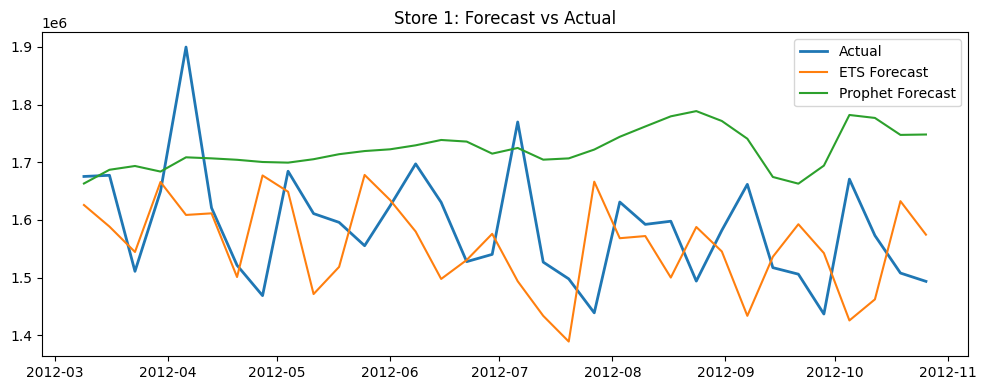


== STORE 20 ==


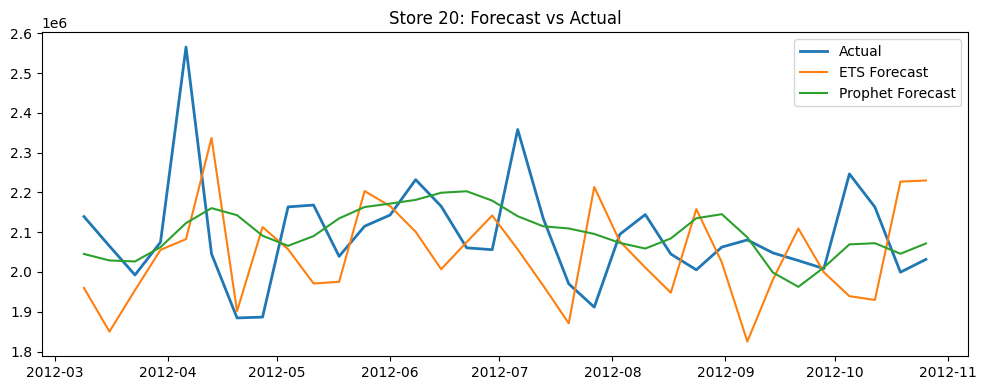


== MODEL PERFORMANCE SUMMARY ==
    ETS_MAPE    ETS_MAE  ETS_Bias  Prophet_MAPE  Prophet_MAE  Prophet_Bias
1       6.25  100174.85 -31546.82          9.62    148934.69     134330.71
20      6.95  147852.87 -47461.89          4.58     96867.26       6289.45


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as ski
import statsmodels as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")



# 2 LOAD DATA

df = pd.read_csv("Walmart_Sales.csv")
# Dates are stored as day-month-year (e.g., 31-12-2024), so parse with dayfirst
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort
df = df.sort_values(['Store', 'Date'])


# 3 SELECT STORES

stores_selected = [1, 20]
df = df[df['Store'].isin(stores_selected)].copy()


# 4 FEATURE ENGINEERING

def create_features(data):
    data = data.copy()
    data['lag_1'] = data['Weekly_Sales'].shift(1)
    data['lag_2'] = data['Weekly_Sales'].shift(2)
    data['lag_4'] = data['Weekly_Sales'].shift(4)

    data['roll_4'] = data['Weekly_Sales'].rolling(4).mean()
    data['roll_8'] = data['Weekly_Sales'].rolling(8).mean()

    return data


df_feat = (
    df.groupby('Store', group_keys=False)
      .apply(create_features)
      .dropna()
)


# 5 TRAIN–TEST SPLIT

def train_test_split_ts(data, split_ratio=0.75):
    split_point = int(len(data) * split_ratio)
    train = data.iloc[:split_point]
    test = data.iloc[split_point:]
    return train, test


results = {}


# 6 MODELING LOOP (STORE BY STORE)

for store in stores_selected:
    print(f"\n== STORE {store} ==")

    store_df = df_feat[df_feat['Store'] == store].set_index('Date').sort_index()

    # Skip if the store does not exist in the dataset
    if store_df.empty:
        print(f"Store {store} has no data. Skipping.")
        continue

    # Ensure DatetimeIndex has weekly frequency for ExponentialSmoothing
    # Infer frequency or set to weekly if not detected
    if store_df.index.freq is None:
        inferred_freq = pd.infer_freq(store_df.index)
        if inferred_freq:
            store_df.index.freq = inferred_freq
        else:
            # Set to weekly frequency if inference fails
            store_df.index = pd.DatetimeIndex(store_df.index, freq='W')

    train, test = train_test_split_ts(store_df)


    # 6A BASELINE MODEL: ETS
    # ExponentialSmoothing needs at least 2 full seasonal cycles
    # For seasonal_periods=52, we need at least 104 data points
    if len(train) >= 104:
        ets_model = ExponentialSmoothing(
            train['Weekly_Sales'],
            trend='add',
            seasonal='add',
            seasonal_periods=52
        ).fit()
    elif len(train) >= 4:
        # Use smaller seasonal period if not enough data for 52
        # Need at least 2 cycles, so max seasonal_periods = len(train) // 2
        seasonal_periods = max(2, len(train) // 2)
        ets_model = ExponentialSmoothing(
            train['Weekly_Sales'],
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_periods
        ).fit()
    else:
        # Not enough data for seasonal component, use trend only
        ets_model = ExponentialSmoothing(
            train['Weekly_Sales'],
            trend='add',
            seasonal=None
        ).fit()

    ets_forecast = ets_model.forecast(len(test))


    # 6B PROPHET MODEL

    prophet_df = store_df.reset_index()[[
        'Date', 'Weekly_Sales', 'Holiday_Flag',
        'Fuel_Price', 'CPI', 'Unemployment'
    ]]

    prophet_df.rename(columns={
        'Date': 'ds',
        'Weekly_Sales': 'y'
    }, inplace=True)

    train_p = prophet_df.iloc[:len(train)]
    test_p = prophet_df.iloc[len(train):]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    regressors = ['Holiday_Flag', 'Fuel_Price', 'CPI', 'Unemployment']
    for r in regressors:
        model.add_regressor(r)

    model.fit(train_p)

    forecast = model.predict(test_p)

    prophet_forecast = forecast['yhat'].values


    # 7 EVALUATION

    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def bias(y_true, y_pred):
        return np.mean(y_pred - y_true)

    metrics = {
        'ETS_MAPE': mape(test['Weekly_Sales'], ets_forecast),
        'ETS_MAE': mean_absolute_error(test['Weekly_Sales'], ets_forecast),
        'ETS_Bias': bias(test['Weekly_Sales'], ets_forecast),

        'Prophet_MAPE': mape(test['Weekly_Sales'], prophet_forecast),
        'Prophet_MAE': mean_absolute_error(test['Weekly_Sales'], prophet_forecast),
        'Prophet_Bias': bias(test['Weekly_Sales'], prophet_forecast)
    }

    results[store] = metrics


    # 8 PLOT FORECAST VS ACTUAL

    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test['Weekly_Sales'], label='Actual', linewidth=2)
    plt.plot(test.index, ets_forecast, label='ETS Forecast')
    plt.plot(test.index, prophet_forecast, label='Prophet Forecast')
    plt.title(f"Store {store}: Forecast vs Actual")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 9 RESULTS SUMMARY
results_df = pd.DataFrame(results).T
print("\n== MODEL PERFORMANCE SUMMARY ==")
print(results_df.round(2))
